In [1]:
import pennylane as qml
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code
import numpy as np
import matplotlib.pyplot as plt

In [2]:
A = np.array(
    [
        [-0.51192128, -0.51192128, 0.6237114, 0.6237114],
        [0.97041007, 0.97041007, 0.99999329, 0.99999329],
        [0.82429855, 0.82429855, 0.98175843, 0.98175843],
        [0.99675093, 0.99675093, 0.83514837, 0.83514837],
    ]
)

alphas = np.arccos(A).flatten()
alphas

array([2.10821619, 2.10821619, 0.89731443, 0.89731443, 0.243873  ,
       0.243873  , 0.00366333, 0.00366333, 0.60183422, 0.60183422,
       0.19129715, 0.19129715, 0.08063288, 0.08063288, 0.58239385,
       0.58239385])

In [4]:
thetas = compute_theta(alphas)
thetas

array([0.58865313, 0.        , 0.        , 0.16998594, 0.23537376,
       0.        , 0.        , 0.36101237, 0.32848621, 0.        ,
       0.        , 0.00729926, 0.19279192, 0.        , 0.        ,
       0.22461361])

In [5]:
ancilla_wires = ["ancilla"]

s = int(np.log2(A.shape[0]))
print(s)
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]

2


In [6]:
code = gray_code(2 * np.log2(len(A)))
n_selections = len(code)

control_wires = [
    int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % n_selections], 2)))
    for i in range(n_selections)
]

wire_map = {control_index: wire for control_index, wire in enumerate(wires_j + wires_i)}

In [7]:
code = gray_code(2 * np.log2(len(A)))
n_selections = len(code)

control_wires = [
    int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % n_selections], 2)))
    for i in range(n_selections)
]

wire_map = {control_index: wire for control_index, wire in enumerate(wires_j + wires_i)}

In [8]:
def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


def UB(wires_i, wires_j):
    for w_i, w_j in zip(wires_i, wires_j):
        qml.SWAP(wires=[w_i, w_j])


def HN(input_wires):
    for w in input_wires:
        qml.Hadamard(wires=w)

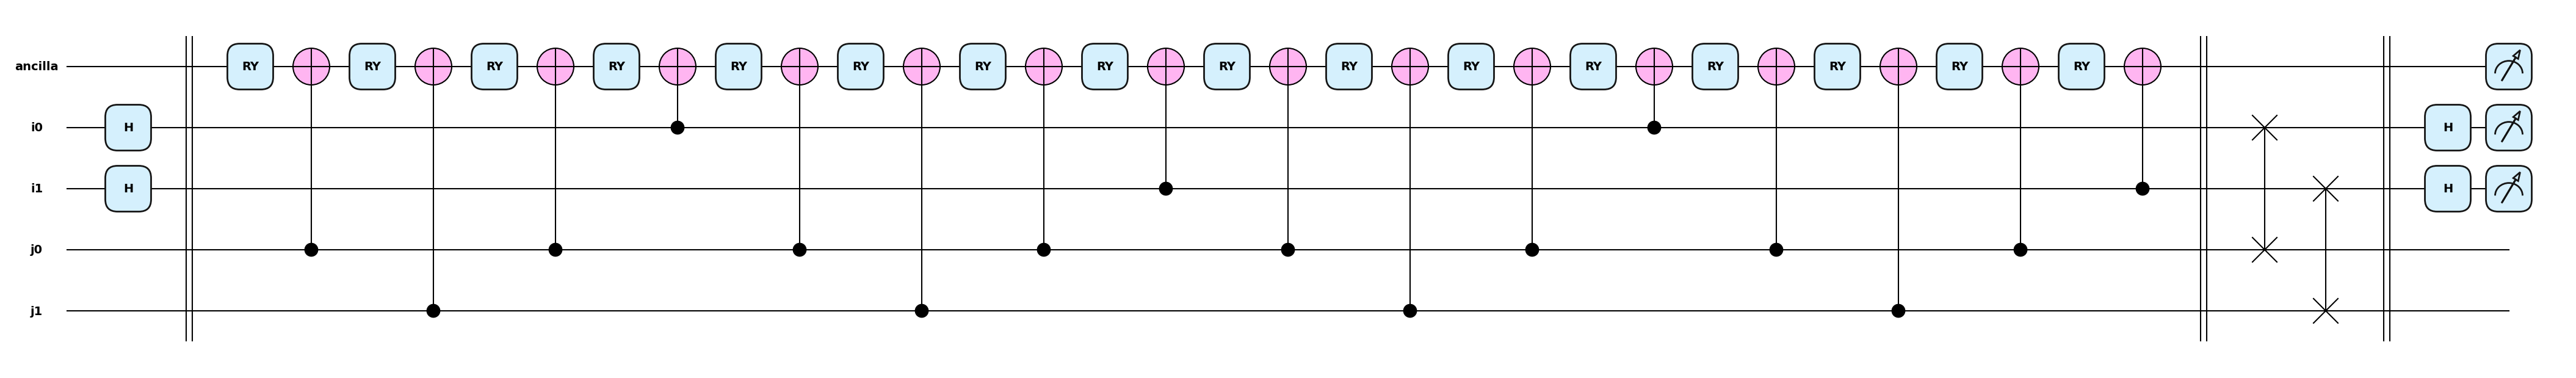

In [9]:
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev)
def circuit():
    HN(wires_i)
    qml.Barrier()  # to separate the sections in the circuit
    UA(thetas, control_wires, ancilla_wires)
    qml.Barrier()
    UB(wires_i, wires_j)
    qml.Barrier()
    HN(wires_i)
    return qml.probs(wires=ancilla_wires + wires_i)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

In [10]:
print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0 : len(A), 0 : len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")

Original matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 

Block-encoded matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 



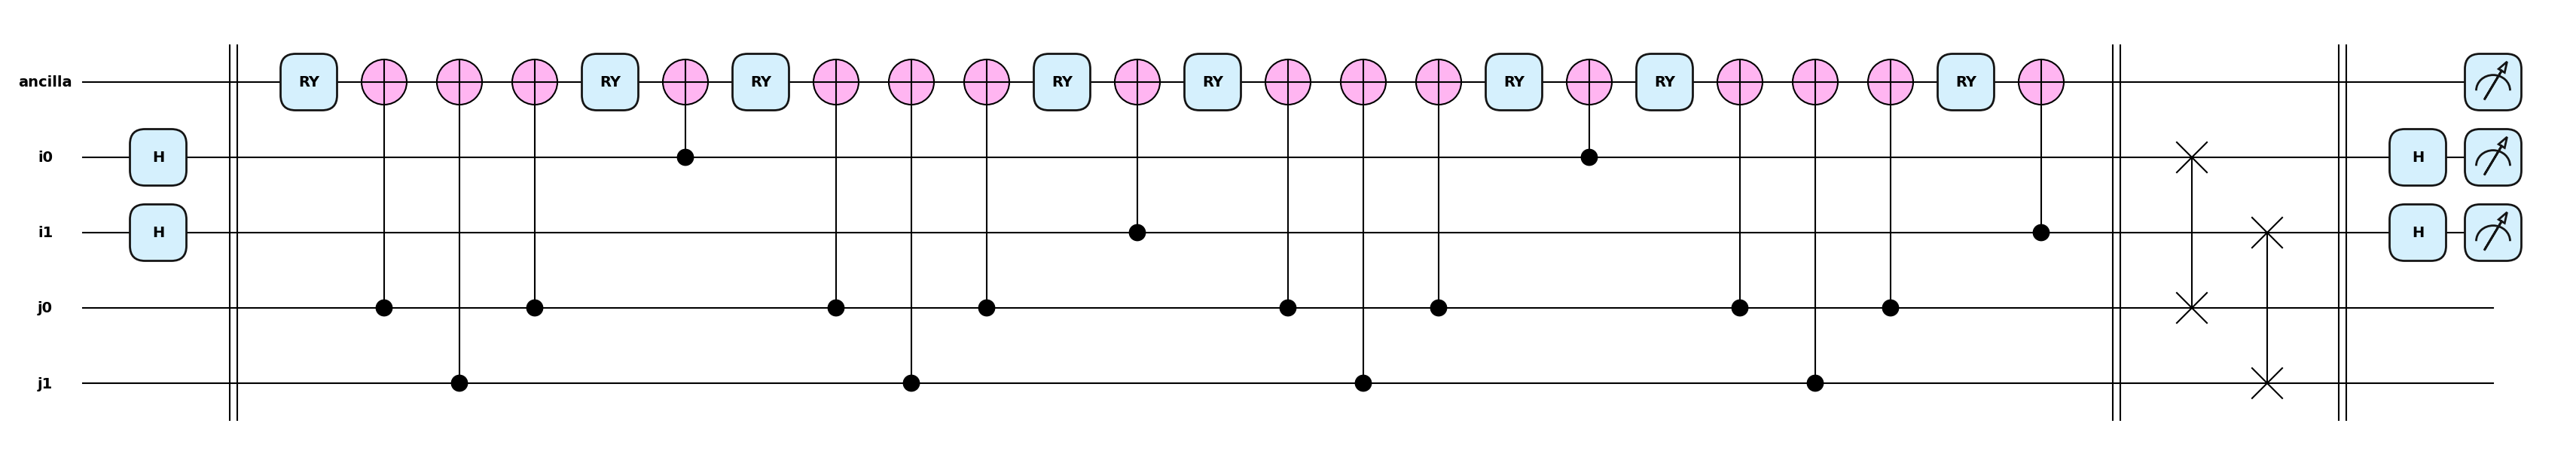

In [11]:
tolerance = 0.01


def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

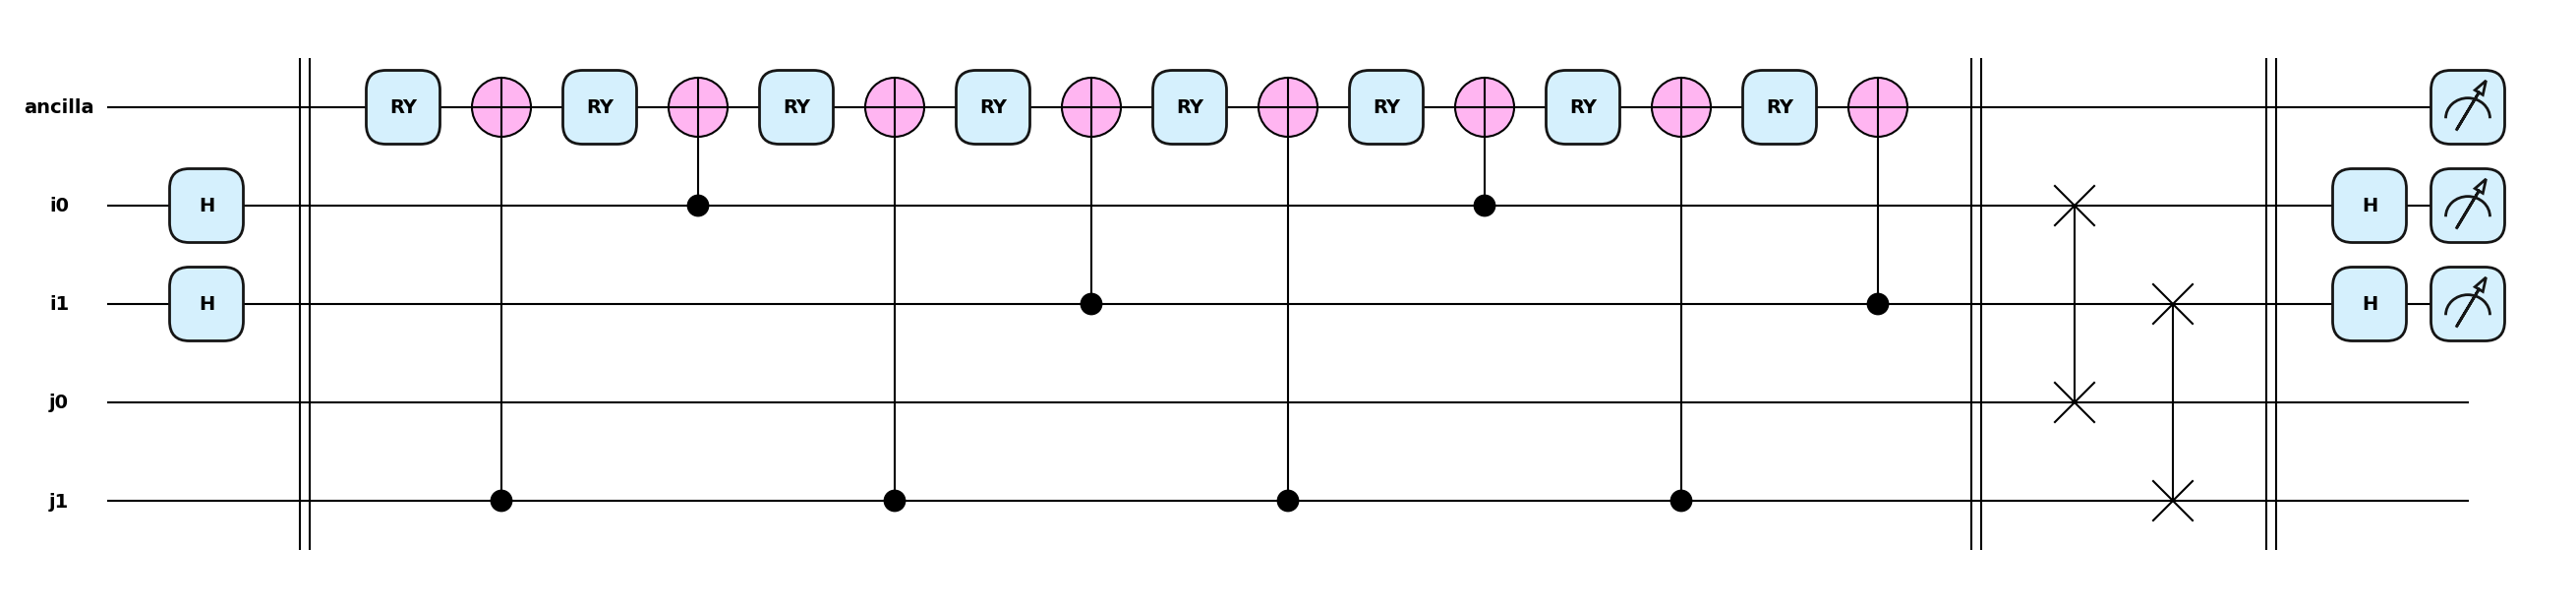

Original matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 

Block-encoded matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 



In [12]:
def UA(thetas, control_wires, ancilla):
    nots = []
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            for c_wire in nots:
                qml.CNOT(wires=[c_wire] + ancilla)
            qml.RY(2 * theta, wires=ancilla)
            nots = []
        if (cw := wire_map[control_index]) in nots:
            del nots[nots.index(cw)]
        else:
            nots.append(wire_map[control_index])
    for c_wire in nots:
        qml.CNOT([c_wire] + ancilla)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0 : len(A), 0 : len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")

In [ ]:
from pennylane.templates.embeddings import amplitude

In [ ]:
amplicircuit = amplitude(A, wires=ancilla_wires + wires_i + wires_j)